***
*Project:* Helmholtz Machine on Niche Construction

*Author:* Jingwei Liu, Computer Music Ph.D., UC San Diego
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">Document 7</span> 

# Helmholtz Machine Class

In this version, we made some improvements based on previous development and experiments:

- We struggled with adding bias to different types of layers, including instantiation layer, MLP hidden layer, data layer. Based on our first round of experiments, the effect of having bias seems ambiguous, only data bias improved the model performance. In this version, we got rid of the confusing and redundant bias choice, integrating it into a more scientific framework -- batch normalization. By performing batch normalization, we recentered the pre-activation term in each layer which gives better structured layer values and derivatives. By adaptive scaling and bias, we attain some control over the mean and variance of all layers.
- In the previous version, we pointed out the effect and variability of binary outcomes of sampling layers. We tried to change the classical binary outcomes {0,1} to {-1,1}, and hoped for better performance. However, the modified values seem down-performed the vanillas version for certain reasons. In this version, we add an option to parameterize the binary outcomes of each sampling layer, which may improve the results comparing to predefined values.
- We retained the deep structure of hidden layers, although this feature didn't make much difference in the control experiments. As means to promote the correlation between two adjacent sampling layers, we believe this feature will take effect in following experiments.

Something new:

- **Adaptive learning rate.** In the previous experiments, we set the learning rate manually, which is quite inconvenient and confusing, since it's difficult to know what learning rate is suitable and when to change it. Due to the nature of wake-sleep algorithm, it's infeasible to train a decreasing loss curve and use it to evaluate the model performance. In this version we take the advantage of Taylor expansion and designed some mechanism to modify the learning rate. This feature is applicable to parameter-specific learning rate design (instead of one learning rate for all parameters), but this feature is still under test.

- **Layer normalization learning rate.** In Document 6, we pointed out that the values of derivatives are not necessary for achieving decreasing loss, only its sign (+ or -) matters. In this version we made our first attempt on this feature. For the parameter matrix $W$, its rows are normalized by batch normalization, while the inside row distribution is not modifiable. We designed a layer-norm learning rate, which adjusts the learning rate of each parameter within a row separately to diversify the row distribution, namely increasing its entropy.

- **MI (mutual information) diversifying training algorithm.** Experimented on the wake-sleep algorithm in previous experiments, it produces too many outliers due to its training on stochastic sampling. It works in certain cases but not applicable to any data distribution. Therefore, based on my understanding, I proposed a new traning algorithm based on maximizing mutual information of adjacent sampling layers, and hope this algorithm could improve model performance and training accuracy.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The model structure looks like below:

<img src="Modern.jpg" style="width:800px">
<caption><center> **Figure 1**: Modern Helmholtz Machine. Blue neurons represent sampling layers, where the neurons take binary values. Orange neurons indicate the inserted activations, where the neurons take value in real numbers in given range.    </center></caption>

The skeleton of the model is given by the sampling layers (blue neurons) where each neuron represents a Bernoulli variable. 

<img src="Helm_global.jpg" style="width:700px">
<caption><center> **Figure 2**: External structure of the Helmholtz Machine, composed of sampling layers. Each adjacent pair may be concatenated by hidden activation layers.    </center></caption>

The internal structure of adjacent sampling layers:

<img src="muti-bernoulli.jpg" style="width:800px">
<caption><center> **Figure 3**: Multivariate Bernoulli Distribution. In wake phase, we go from input $\mathbf{x}$ to output $\mathbf{y}$ by weight $\Phi$. Blue neurons represent sampling layers, where each neuron takes binary value and is computed as an independent Bernoulli variable. Orange neurons are inserted activations, which transform a shallow neural network with one-step prameter updating to deep neural network with backpropogation.
</center></caption>

The computation and parameter updation of the Helmholtz machine is layer-separated by instance sampling. Therefore, the programming architecture of this model is modular -- we perform all functions on the submodule in Figure 3 then assemble them as the skeleton in Figure 2 to achieve the Helmholtz machine as shown in Figure 1. The `Helmholtz_machine class` describes this skeleton in Figure 2.

In [2]:
def sigmoid(x):
    y = 1/(1+np.exp(-x))
    return y

#### Define model structure

n_dz -- number of neurons for each layer, numpy array of shape (n+1,m), where m is the number of instantiation layers, 
n is the maximum number of inserted layers between adjacent instantiation layers.

A neural network in Figure 1 has structure ndarray:
$$
n_{dz} = 
\begin{pmatrix}
10 & 8 & 6 & 3 & 1 \\
9 & 0 & 5 & 0 & 0 \\
0 & 0 & 4 & 0 & 0  \\
\end{pmatrix}
$$

The first row gives the number of neurons in each instantiation layer. The second row represents the first inserted layer, and there is a 9-neuron layer inserted between $d_0$ and $z_1$, a 5-neuron layer inserted between $z_2$ and $z_3$. The third row represents the second inserted layer, and there is only one 4-neuron layer inserted between $z_2$ and $z_3$ above the first 5-neuron inserted layer. Obviously, $n_{dz}(i,k) \ne 0$ if and only if $n_{dz}(i,j) \ne 0, \forall j < k$; the last column of  $n_{dz}$ is all zero except for the value in the first row.

In this class, we have following quantities for computation:

- Parameters
    - Matrix $\phi$, of shape $(n_l,n_x+2)$. The first $(n_l,n_x)$ is weight matrix from layer $x$ to $l$, penultimate column $(n_l,1)$ is adaptive bias, last column $(n_l,1)$ is adaptive scale. Matrix $\phi$'s are for every concatenated layers, dictionary of dictionary.
    - Binary outcomes of every sampling layer, matrix $Scalar$ of shape $(n_{layer},2)$, in this example $n_{layer}=5$. This matrix, the sampled binary values, are shared between wake and sleep phases.
    
- Statistics
    - Batch normalization statistics, statistical mean and variance of each layer, matrix $norm$ of shape $(n_l,3)$, same length as parameter set. First column is batch summation $\sum_i z_i$; second column is batch square sum $\sum_i z_i^2$; third column is fixed bias placeholder that pulls the pre-activition mean to $0$. Separate statistics for wake and sleep phases, dictionary of dictionary.
    - Learning rate update criteria. 
    - Latent assignment distribution
- Control variables
    - add_norm: control whether to add the current instance to batch normalization counts.
    - 
    - learning rate: assign different learning rate to each submodule, matrix of shape $(2,n_{layer}-1)$. First row stores lr for wake phase modules (last entry is idle), 3 modules; second row stores lr for sleep phase modules, 4 modules.
    
- Derivatives
    - 

In [394]:
def one_step_para_init(n_dz_slice,init_type):
    """
    Arguments:
    n_dz_slice -- 2 columns of n_dz
    init_type -- "zero" or "random", "zero" assigns 0 to all parameters, "random" samples from standard Gaussian

    Returns:
    Phi, Theta -- -2 column bias, -1 column scale
    norm_set -- statistical mean and variance of each pre-activation layer. Python dictionary of length l, with each value 
    a numpy array of shape (n_neuron+1,2), last row is counts, column 1: sum(z_i); column 2: sum(z_i**2); column 3: bias placeholder
    """
    l = np.where(n_dz_slice[:,0] != 0)[0].size  # number of layers
    layer_vt = np.append(n_dz_slice[:l,0],n_dz_slice[0,1])
    Phi = {}
    Theta = {}
    norm_wake = {}
    norm_sleep = {}
    for i in range(l):
        if init_type == "zero":
            Phi["Phi_" + str(i) + str(i+1)] = np.zeros((layer_vt[i+1],layer_vt[i]+2))
            Theta["Theta_" + str(l-i) + str(l-i-1)] = np.zeros((layer_vt[l-i-1],layer_vt[l-i]+2))
        elif init_type == "random":
            Phi["Phi_" + str(i) + str(i+1)] = np.random.randn(layer_vt[i+1],layer_vt[i]+2)
            Theta["Theta_" + str(l-i) + str(l-i-1)] = np.random.randn(layer_vt[l-i-1],layer_vt[l-i]+2)
        else:
            raise Exception("Wrong Init Type")
        Phi["Phi_" + str(i) + str(i+1)][:,-1] = 1          #scale
        Theta["Theta_" + str(l-i) + str(l-i-1)][:,-1] = 1
        Phi["Phi_" + str(i) + str(i+1)][:,-2] = 0              #bias
        Theta["Theta_" + str(l-i) + str(l-i-1)][:,-2] = 0
        
        norm_wake["l_" + str(i+1)] = np.zeros((layer_vt[i+1]+1,3))
        norm_sleep["l_" + str(l-i-1)] = np.zeros((layer_vt[l-i-1]+1,3))
        
    return Phi,Theta,norm_wake,norm_sleep

In [395]:
def one_step_forward(x,activation_type,parameter_set,norm_set,add_norm):
    """
    Arguments:
    x -- input instantiation layer, numpy array of shape (n,1)
    activation_type -- we provide 2 choices of activation functions: tanh(x) and sigmoid(x)
    parameter_set -- parameters from x to y. Python dictionary of length l. The keys are ordered sequentially from layer x to y.
    norm_set -- statistical mean and variance of each pre-activation layer. Python dictionary of length l, with each value 
    a numpy array of shape (n_neuron+1,2), last row: counts; column 1: sum(z_i); column 2: sum(z_i**2); column 3: bias placeholder
    add_norm -- True or False. Update norm matrix or not
    
    Returns:
    G -- activation of each layer including x
    q -- probability of layer y
    """
    l = len(parameter_set)
    p_keys = [*parameter_set]
    n_keys = [*norm_set]
    G = {'z0': x}
    g = x
    
    for i in range(l):
        phi = parameter_set[p_keys[i]]
        norm = norm_set[n_keys[i]]
        
        pre_ac = np.matmul(phi[:,:-2],g)+norm[:-1,2:]  # pre-activation; bias placeholder
        K = phi[:,-1:] * pre_ac + phi[:,-2:-1]  # rescale linear term
        if activation_type == "sigmoid":
            g = sigmoid(K)
        elif activation_type == "tanh":
            g = np.tanh(K)
        if i == l-1:
            g = sigmoid(K)
        G['z'+str(i+1)] = g
        
        if add_norm == True:
            norm[:-1,0:1] += pre_ac
            norm[-1,0] += 1
            norm[:-1,1:2] += pre_ac**2
            norm[-1,1] += 1
            norm_set[n_keys[i]] = norm        
    return G,g

In [669]:
def one_step_update(x,y,G,activation_type,parameter_set,value_set,norm_set,lr,\
                    fz_binary,fz_scale,fz_W,layer_norm,layer_norm_rate,check_lr):
    """
    Arguments:
    x -- input sampling layer, numpy array of shape (n,1)
    y -- target sampling layer, numpy array of shape (m,1)
    G -- output of one_step_forward_norm, activation of each layer including x
    activation_type -- we provide 2 choices of activation functions: tanh(x) and sigmoid(x)
    parameter_set -- parameters from x to y. Each array phi: -2 column bias, -1 column scale
    value_set -- list or array [[a_x,b_x],[a_y,b_y]], where a is the positive outcome and b is the negative outcome of a Bernoulli experiment
    norm_set -- statistical mean and variance of each pre-activation layer. Python dictionary of length l, with each value 
    a numpy array of shape (n_neuron+1,3), last row: counts; column 1: sum(z_i); column 2: sum(z_i**2); column 3: bias placeholder
    lr -- learning rate, decimals
    fz_binary -- True or Flase. If True, [a_x,b_x] are fixed values; if False, update [a_x,b_x]
    fz_scale -- True or Flase. If True, last 2 columns of phi are fixed; if False, update adaptive scale and bias
    fz_W -- True or Flase. If True, freeze weights; if False, update weights
    layer_norm -- True or Flase, whether to adjust row distribution of W (more evenly distributed) by adjusting the 
    updating rate "layer_norm_rate" of dW
    check_lr -- True or Flase. If True, check current lr and update it as needed
    
    Returns:
    parameter_set -- updated parameters
    loss -- value of loss function before updating, a number
    grad_set -- gradients of parameters
    lr -- updated learning rate
    """
    
    a_x = value_set[0,0]
    b_x = value_set[0,1]
    a_y = value_set[1,0]
    b_y = value_set[1,1]
    l = len(parameter_set)
    p_keys = [*parameter_set]
    n_keys = [*norm_set]
    grad_set = {}
    
    # derivatives
    q = G['z'+str(l)]
    u = q - (y-b_y)/(a_y-b_y)   #[n_y,1]
    loss = -np.sum(((y-b_y)*np.log(q) + (a_y-y)*np.log(1-q))/(a_y-b_y))  # layer entropy loss
    if np.where(np.abs(y - a_y) < 1e-8)[0].size + np.where(np.abs(y - b_y) < 1e-8)[0].size != y.size:
        raise Exception("Incorrect output layer" + str(a_y)+ " "+str(b_y)+ " "+str(y))
    # a = g(scale * [(Wz+b-mean)/deviation] + bias)
    for i in range(l-1,-1,-1):
        phi = parameter_set[p_keys[i]]
        grad_set['d_'+p_keys[i]] = np.zeros(phi.shape)
        W = phi[:,:-2]        #[n_y,n_z]
        bias = phi[:,-2:-1]   #[n_y,1]
        scale = phi[:,-1:]    #[n_y,1]
        
        z = G['z'+str(i)]      #[n_z,1]
        
        if fz_W == False:
            dW = np.outer(u*scale,z)     #[n_y,n_z]
            grad_set['d_'+p_keys[i]][:,:-2] = dW
            # update weights
            if layer_norm == True:
                dW = layer_lr(W, dW, rate=layer_norm_rate)
            parameter_set[p_keys[i]][:,:-2] -= lr * dW
        
        if fz_scale == False:
            norm = norm_set[n_keys[i]]      #[n_y,3]
            b = norm[:-1,2:]                #[n_y,1]
            N = np.matmul(W,z)+b   #[n_y,1]
            d_scale = u * N        #[n_y,1]
            d_bias = u             #[n_y,1]
            parameter_set[p_keys[i]][:,-1:] -= lr * d_scale
            parameter_set[p_keys[i]][:,-2:-1] -= lr * d_bias
            grad_set['d_'+p_keys[i]][:,-1:] = d_scale
            grad_set['d_'+p_keys[i]][:,-2:-1] = d_bias
        
        dz = np.matmul(W.T,u*scale)  #[n_z,1]
        if i > 0:
            if activation_type == "sigmoid":
                u = dz * z * (1-z)
            elif activation_type == "tanh":
                u = dz * (1-z**2)
        else:
            # input layer, parameters a_x, b_x
            if fz_binary == False:
                d_ax = np.mean(dz[np.where(np.abs(x - a_x) < 1e-8)[0]]) # use mean instead of sum
                d_bx = np.mean(dz[np.where(np.abs(x - b_x) < 1e-8)[0]])
                if np.where(np.abs(x - a_x) < 1e-8)[0].size + np.where(np.abs(x - b_x) < 1e-8)[0].size != dz.size:
                    raise Exception("Incorrect input layer" + str(a_x)+ " "+str(b_x)+ " "+str(x))
                a_x -= lr * d_ax
                b_x -= lr * d_bx
                value_set[0,:] = [a_x,b_x]
    
    if check_lr == True:
        G,q = one_step_forward(x,activation_type,parameter_set,norm_set,add_norm=False)
        loss_new = -np.sum(((y-b_y)*np.log(q) + (a_y-y)*np.log(1-q))/(a_y-b_y))  # layer entropy loss
        delta_loss = loss - loss_new
        delta_f = 0
        for keys in grad_set:
            delta_f += np.sum(grad_set[keys]**2)
        delta_f *= lr
        print("delta_loss: "+ str(delta_loss), "delta_f: "+ str(delta_f))
        if delta_loss < delta_f:
            lr /= delta_f/delta_loss
            print("learning rate change: " + str(lr))
    
    return lr,loss,grad_set

In [661]:
def layer_lr(W, dW, rate):
    """
    adjust row distribution of W (more evenly distributed) by adjusting the updating rate of dW
    Arguments:
    W -- phi[:,:-2], numpy array of sahpe (n_z,n_x)
    dW -- derivatives of W
    rate -- 10 folds, x rate; 100 folds, x 2 rate
    
    Returns:
    layer_lr
    """
    multiple = np.log10(np.abs(W)/np.min(np.abs(W),axis=1,keepdims=True)).astype(int)
    index = np.where((multiple > 0) & (W*dW > 0))
    dW[index] *= rate
    return dW

In [662]:
def one_step_norm_update(parameter_set,norm_set):
    """
    Arguments:
    parameter_set -- parameters from x to y. Python dictionary of length l. The keys are ordered sequentially from layer x to y.
    Each array phi has: -2 column bias, -1 column scale
    norm_set -- statistical mean and variance of each pre-activation layer. Python dictionary of length l, with each value 
    a numpy array of shape (n_neuron+1,2), last row: counts; column 1: sum(z_i); column 2: sum(z_i**2); column 3: bias placeholder
    
    Returns:
    parameter_set -- updated parameters
    norm_set -- reset mean, variance; update bias placeholder
    """
    l = len(parameter_set)
    p_keys = [*parameter_set]
    n_keys = [*norm_set]
    
    for i in range(l):
        phi = parameter_set[p_keys[i]]  #[n_z,n_x+2]
        norm = norm_set[n_keys[i]]      #[n_z,1]
        mean = norm[:-1,0:1]/norm[-1,0]
        variance = norm[:-1,1:2]/norm[-1,1] - mean**2
        print("mean: ", mean)
        print("variance: ", variance)
        
        parameter_set[p_keys[i]][:,:-2] = phi[:,:-2]/np.sqrt(variance)  # scale every row of W by deviations
        b = norm[:-1,2:]
        norm_set[n_keys[i]][:-1,2:] = (b-mean)/np.sqrt(variance) # update bias placeholder
        norm_set[n_keys[i]][:,:2] = 0
    return parameter_set,norm_set

In [663]:
def decimalize(bnr):
    """
    Arguments: bnr -- numpy array of binary values {0,1}, of shape (width,n)
    Returns: dcm -- a decimalized intger array in range [0,2**width), shape (n,)
    """
    width = bnr.shape[0]
    n = bnr.shape[1]
    dcm = np.zeros(n,dtype=int)
    for i in range(n):
        binary = ''.join(bnr[:,i].reshape(width,).astype(str))
        dcm[i] = int(binary,2)
    return dcm

In [664]:
def binarilize(dcm,width):
    """
    Arguments: dcm -- a decimalized intger array in range [0,2**width), shape (n,)
    Returns:   bnr -- numpy array of binary values {0,1}, of shape (width,n)
    """
    n = len(dcm)
    bnr = np.zeros((width,n),dtype=int)
    for i in range(n):
        bnr[:,i:i+1] = np.array(list(np.binary_repr(dcm[i], width=width))).astype(int).reshape(-1,1)
    return bnr

In [1623]:
def one_step_prob_matrix(activation_type,n_x,parameter_set,norm_set):
    x_ind = np.arange(2**n_x)
    X = binarilize(x_ind,n_x)  #(n_x,2**n_x)
    G,q = one_step_forward(X,activation_type,parameter_set,norm_set,add_norm=False)
    
    n_y = q.shape[0]           # q:(n_y,2**n_x)
    y_ind = np.arange(2**n_y)
    Y = binarilize(y_ind,n_y)  #(n_y,2**n_y)
    
    prob_mtx = np.zeros((2**n_x+1,2**n_y+1)) 
    # probability from X to Y, last row is sum, last column is row entropy
    for i in range(2**n_x):
        prob_mtx[i,:-1] = np.prod(q[:,i:i+1]**Y * (1-q[:,i:i+1])**(1-Y),axis=0)
    prob_mtx[-1,:-1] = np.mean(prob_mtx[:-1,:-1],axis=0)
    prob_mtx[:,-1] = -np.sum(prob_mtx[:,:-1]*np.log(prob_mtx[:,:-1]),axis=1)
    return prob_mtx

In [1624]:
np.sum(n_dz,axis=0)

array([10,  8,  6,  3,  1])

In [1625]:
def init_M(n_x,n_y):
    """
    Arguments:
    n_x -- number of neurons in input layer
    n_y -- number of neurons in output layer
    
    Returns:
    M -- count matrix, numpy array of shape (2**n_x+1, 2**n_y+2), last row: summation; -2 column: summation; 
    last column: row entropy
    """
#     M = np.zeros((2**n_x+1,2**n_y+2))
#     epsilon = 1e-10
#     M[0:2**n_x,0:2**n_y] = epsilon
#     M[-1,:-2] = np.sum(M[:-1,:-2],axis=0)
#     M[:,-2] = np.sum(M[:,:-2],axis=1)
# #     M[:,-1] = np.log(2**n_y)

    M = np.zeros((2**n_x+1,2**n_y+1)) #last row: sum; last column: entropy
    
    return M

In [1626]:
def entropy(H_prev,s,a):
    """
    Iterative formula for entropy:
    H_+1 = (s(H-log(s)) + (s+1)log(s+1) + [alog(a) - (a+1)log(a+1)])/(s+1)
    
    Arguments:
    H_prev -- previous entropy
    s -- total counts
    a -- counts for the category being modified
     
    Returns:
    H -- updated entropy
    """
    H = (s*(H_prev-np.log(s)) + (s+1)*np.log(s+1) + [a*np.log(a) - (a+1)*np.log(a+1)])/(s+1)
    return H

In [1644]:
def mutual_info(Input):
    """
    Find y for given x that increases the layer-wise accumulative mutual information
    Iterative formula for entropy:
    H_+1 = (s(H-log(s)) + (s+1)log(s+1) + [alog(a) - (a+1)log(a+1)])/(s+1)
    
    s = 1 -> H_+1 = H/2 + log(2) + [alog(a) - (a+1)log(a+1)]/2
    
    Arguments:
    Input -- numpy array of shape (2,m+2), with each row comprises 
    [counts for m categories separately, sum of counts, entropy of this row]
    first row: H(Y|x)    second row: H(Y) [summation over x]
    
    Returns:
    MI_index -- list of indices of Y where the mutual information increases when this category counts +1, numpy array of shape (k, )
    MI -- mutual information of each choice, numpy array of shape (k, )
    """
#     s = Input[:,-2:-1]   #(2,1)
#     H = Input[:,-1:]     #(2,1)
#     C = s*(H - np.log(s)) + (s+1)*np.log(s+1)   #(2,1)
    
#     M = Input[:,:-2]     #(2,m)
#     D = M*np.log(M) - (M+1)*np.log(M+1)     #(2,m)
#     H_new = (C + D)/(s+1)      #(2,m)

    H = Input[:,-1:]     #(2,1)
    M = Input[:,:-1]     #(2,m)
    H_new = H/2 + np.log(2) + (M*np.log(M) - (M+1)*np.log(M+1))/2  # +1
    
    
    MI = H_new[1,:] - H_new[0,:]
#     I_diff = I - (H[1,:] - H[0,:])  #(m, )
#     MI_index = np.where(I_diff > 0)[0]
#     MI = I[MI_index]
    
    return MI,H_new

In [1373]:
n_x = 3
n_y = 2
M = init_M(n_x,n_y)
M

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [1292]:
check_M(M)

C:\Users\79244\AppData\Local\Temp\ipykernel_17324\1705882109.py:16: RuntimeWarning: divide by zero encountered in log
  elif np.all(np.abs(M[:,-1] + np.sum(M[:,:-2]*np.log(M[:,:-2]),axis=1)/M[:,-2]-np.log(M[:,-2])) > epsilon):
C:\Users\79244\AppData\Local\Temp\ipykernel_17324\1705882109.py:16: RuntimeWarning: invalid value encountered in multiply
  elif np.all(np.abs(M[:,-1] + np.sum(M[:,:-2]*np.log(M[:,:-2]),axis=1)/M[:,-2]-np.log(M[:,-2])) > epsilon):


True

In [1076]:
cat_x = 2
Input = M[[cat_x,-1],:]
Input

array([[1.00000000e-10, 1.00000000e+00, 1.00000000e-10, 1.00000000e-10,
        1.00000000e+00, 6.65323756e-09],
       [8.00000000e-10, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        3.00000000e+00, 1.09861229e+00]])

In [1077]:
s = Input[:,-2:-1]   #(2,1)
H = Input[:,-1:]     #(2,1)
C = s*(H - np.log(s)) + (s+1)*np.log(s+1)   #(2,1)
Mtx = Input[:,:-2]     #(2,m)
D = Mtx*np.log(Mtx) - (Mtx+1)*np.log(Mtx+1)     #(2,m)
H_new = (C + D)/(s+1)      #(2,m)
H_new

array([[6.93147183e-01, 3.43059081e-09, 6.93147183e-01, 6.93147183e-01],
       [1.38629436e+00, 1.03972077e+00, 1.03972077e+00, 1.03972077e+00]])

In [1078]:
I = H_new[1,:] - H_new[0,:]
I

array([0.69314718, 1.03972077, 0.34657359, 0.34657359])

In [1079]:
I_diff = I - (H[1,:] - H[0,:])  #(m, )
I_diff

array([-0.40546511, -0.05889152, -0.75203869, -0.75203869])

In [1080]:
MI_index = np.where(I_diff > 0)[0]
MI_index

array([], dtype=int64)

In [1070]:
MI = I[MI_index]
MI

array([1.09861229, 1.09861229])

In [1071]:
precision = 0.2
q = np.array([[0.5],[0.5]])
var_index = np.where(np.abs(q.reshape(-1,) - 0.5) < precision)[0]
num = len(var_index)
comb = binarilize(np.arange(2**num),num)   #(num, 2**num)
prob = q[var_index]
probability = np.prod(prob**comb * (1-prob)**(1-comb),axis=0)  #(2**num, )
z = (q+0.5).astype(int)
z_all = np.repeat(z, 2**num, axis=1)  #(n_q, 2**num)
z_all[var_index,:] = comb
p_index = decimalize(z_all)   #(2**num, )
p_index

array([0, 1, 2, 3])

In [1072]:
intersect, p_i, MI_i = np.intersect1d(p_index, MI_index,return_indices=True)
intersect

array([0, 1], dtype=int64)

In [1073]:
ind = np.argsort(probability[p_i] * MI[MI_i])[::-1][0]  # the best y's index
cat_y = p_index[p_i[ind]]    # the best y's category
cat_y

1

In [1074]:
M[cat_x,-1] = entropy(M[cat_x,-1],M[cat_x,-2],M[cat_x,cat_y])
M[-1,-1] = entropy(M[-1,-1],M[-1,-2],M[-1,cat_y])
M[cat_x,cat_y] += 1
M[-1,cat_y] += 1
M[cat_x,-2] += 1
M[-1,-2] += 1  

In [1075]:
M

array([[1.00000000e-10, 1.00000000e-10, 1.00000000e-10, 1.00000000e+00,
        1.00000000e+00, 6.65323756e-09],
       [1.00000000e-10, 1.00000000e-10, 1.00000000e+00, 1.00000000e-10,
        1.00000000e+00, 6.65323756e-09],
       [1.00000000e-10, 1.00000000e+00, 1.00000000e-10, 1.00000000e-10,
        1.00000000e+00, 6.65323756e-09],
       [1.00000000e-10, 1.00000000e-10, 1.00000000e-10, 1.00000000e-10,
        4.00000000e-10, 0.00000000e+00],
       [1.00000000e-10, 1.00000000e-10, 1.00000000e-10, 1.00000000e-10,
        4.00000000e-10, 0.00000000e+00],
       [1.00000000e-10, 1.00000000e-10, 1.00000000e-10, 1.00000000e-10,
        4.00000000e-10, 0.00000000e+00],
       [1.00000000e-10, 1.00000000e-10, 1.00000000e-10, 1.00000000e-10,
        4.00000000e-10, 0.00000000e+00],
       [1.00000000e-10, 1.00000000e-10, 1.00000000e-10, 1.00000000e-10,
        4.00000000e-10, 0.00000000e+00],
       [8.00000000e-10, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        3.00000000e+00, 

In [1052]:
p_index[np.argsort(probability)[::-1][0]]

3

In [1109]:
np.argsort(MI)[::-1][0]

1

In [1628]:
def top_samples(q,precision):
    """
    Arguments:
    q -- sigmoid output of a given layer
    precision -- a decimal number in [0,0.5)
    
    Returns:
    p_index -- numpy array of shape (2**num, ), categorical number of possible y's
    probability -- numpy array of shape (2**num, ), probability of each category
    num -- max number of neurons being changed
    """
    
    var_index = np.where(np.abs(q.reshape(-1,) - 0.5) < precision)[0]
    num = len(var_index)
    comb = binarilize(np.arange(2**num),num)   #(num, 2**num)
    prob = q[var_index]
    probability = np.prod(prob**comb * (1-prob)**(1-comb),axis=0)  #(2**num, )
    
    z = (q+0.5).astype(int)
    z_all = np.repeat(z, 2**num, axis=1)  #(n_q, 2**num)
    z_all[var_index,:] = comb
    p_index = decimalize(z_all)   #(2**num, )
        
    return p_index,probability,num

In [1762]:
def determine_y(M,cat_x,q,precision=0.2):
    """
    Arguments:
    M -- count matrix, numpy array of shape (2**n_x+1, 2**n_y+2), last row: summation; -2 column: summation; last column: entropy
    cat_x -- categorical number of given x
    q -- sigmoid output of input x
    precision -- a decimal number in [0,0.5)
    
    Returns:
    M -- updated count matrix
    """
    M_pick = M[[cat_x,-1],:]
    MI,H_new = mutual_info(M_pick)
    p_index,probability,num = top_samples(q,precision)

#     intersect, p_i, MI_i = np.intersect1d(p_index, MI_index,return_indices=True)
#     if intersect.size > 0:
#         ind = np.argsort(probability[p_i] * MI[MI_i])[::-1][0]  # the best y's index
#         cat_y = p_index[p_i[ind]]    # the best y's category
#     else:
#     if MI_index.size == 0:
#         cat_y = p_index[np.argsort(probability)[::-1][0]]
#     else:

#     cat_y = np.argsort(MI)[::-1][0]

    ind = np.argsort(MI[p_index] * np.log(1+probability))[::-1][0]
    cat_y = p_index[ind]
    
#     p_ind = np.argsort(MI)[::-1][0:5]      # top 5 max MI
#     comb = binarilize(p_ind,width=len(q))  # (2**n_y,5)
#     probability = np.prod(q**comb * (1-q)**(1-comb),axis=0)  #(5, )
#     ii = np.argsort(probability * MI[p_ind])[::-1][0]
#     cat_y = p_ind[ii]
        
#     # update count matrix
#     M[cat_x,-1] = entropy(M[cat_x,-1],M[cat_x,-2],M[cat_x,cat_y])
#     M[-1,-1] = entropy(M[-1,-1],M[-1,-2],M[-1,cat_y])
#     M[cat_x,cat_y] += 1
#     M[-1,cat_y] += 1
#     M[cat_x,-2] += 1
#     M[-1,-2] += 1    
    
    return cat_y

In [1763]:
def check_M(M):
    """
    Arguments:
    M -- count matrix, numpy array of shape (2**n_x+1, 2**n_y+1), last row: summation; last column: entropy
    
    Returns:
    """
    flag = True
    epsilon = 1e-8
    if np.all(np.abs(M[-1,:-1] - np.mean(M[:-1,:-1],axis=0)) > epsilon):
        flag = False
        raise Exception("row addition wrong")
    elif np.all(np.abs(np.sum(M[:,:-1],axis=1) - 1) > epsilon):
        flag = False
        raise Exception("column addition wrong")
    elif np.all(np.abs(M[:,-1] + np.sum(M[:,:-1]*np.log(M[:,:-1]),axis=1)) > epsilon):
        flag = False
        raise Exception("entropy computation wrong")
    return flag

In [1764]:
class Helmholtz_machine:

    def __init__(self, n_dz, activation_type, init_lr = 0.1):
        """
        Arguments:
        n_dz -- number of neurons for each layer, numpy array of shape (n+1,m), where m is the number of instantiation layers, 
        n is the maximum number of inserted layers between adjacent instantiation layers
        activation_type -- we provide 2 choices of activation functions: tanh(x) and sigmoid(x)
        init_lr -- initial learning rate, decimal number
        
        Returns:
        n_layer -- number of instantiation layers
        lr -- different learning rate for each submodule, numpy array of shape (2,m-1)
        """
        self.n_dz = n_dz
        self.n_layer = self.n_dz.shape[1]
        self.n_d = n_dz[0,0]
        self.ac = activation_type
        self.lr = np.ones((2,self.n_layer-1))*init_lr
        
    def parameter_init(self,init_type,value_set):
        """
        Arguments:
        init_type -- "zero" or "random", "zero" assigns 0 to all parameters, "random" samples from standard Gaussian
        value_set -- numpy array [a,b], binary outcomes as {positive, negative}

        Returns:
        Phi, Theta -- -2 column bias, -1 column scale. 
        Eg. {Phi_01:{Phi_01,Phi_12}, Phi_12:{Phi_01,Phi_12,Phi_23}}, dictionary of dictionary
        Norm_wake, Norm_sleep -- statistical mean and variance of each pre-activation layer. Norm_wake's last dic is idle.
        Dictionary of dictionary, numpy array of shape (n_neuron+1,3), 
        last row is counts, column 1: sum(z_i); column 2: sum(z_i**2); column 3: bias placeholder
        Scalar -- numpy array of shape (n_layer,2), binary outcomes of every sample layer, shared between wake and sleep phases
        """
        Phi = {}
        Theta = {}
        Norm_wake = {}
        Norm_sleep = {}
        
        for i in range(self.n_layer-1):
            Phi["Phi_"+str(i)+str(i+1)],Theta["Theta_"+str(i+1)+str(i)],Norm_wake['sl_'+str(i+1)], Norm_sleep['sl_'+str(i)] \
            = one_step_para_init(self.n_dz[:,i:i+2],init_type)
            
        self.Phi = Phi
        self.Theta = Theta
        self.Norm_wake = Norm_wake
        self.Norm_sleep = Norm_sleep
        self.Scalar = np.repeat(value_set.reshape(1,-1),self.n_layer,axis=0)
          
    def MI_mtx_init(self):
        MI_matrix = {}
        for i in range(self.n_layer-2):
            MI_matrix["MI_"+str(i)+str(i+1)] = init_M(self.n_dz[0,i],self.n_dz[0,i+1])
        return MI_matrix
    
    def set_control(self,Fz_binary,fz_scale=True,fz_W=False,layer_norm=False,layer_norm_rate=2):
        """
        Arguments:
        Fz_binary -- Boolean list of size n_layer, with last entry always as True
        True or Flase. If True, last 2 columns of phi are fixed; if False, update adaptive scale and bias
        fz_W -- True or Flase. If True, freeze weights; if False, update weights
        layer_norm -- True or Flase, whether to adjust row distribution of W (more evenly distributed) by adjusting the 
        updating rate "layer_norm_rate" of dW
        """
        self.Fz_binary = Fz_binary
        self.fz_scale = fz_scale
        self.fz_W = fz_W
        self.layer_norm = layer_norm
        self.ln_rate = layer_norm_rate
        if fz_scale == False:
            self.Scalar = self.Scalar.astype(float)
    
    def wake_sample(self,d0,add_norm=True):
        """
        Stochastic sample in wake phase
        Arguments:
        d0 -- input pattern in {0,1}, numpy array of shape (n_d, 1)

        Returns:
        Alpha_Q -- assignment of each neuron (binary value), Python dictionary of length m with each key-value pair being 
        a numpy array of shape (n_dz[0,i], 1),i = 0,...m-1
        Norm -- updated mean and variance on every sampling
        """
        a = self.Scalar[0,0]
        b = self.Scalar[0,1]
        S = d0*(a-b)+b  # input layer
        Alpha_Q = {"z0":S}
        for i in range(self.n_layer-2):
            G,q = one_step_forward(S,self.ac,self.Phi["Phi_"+str(i)+str(i+1)],self.Norm_wake['sl_'+str(i+1)],add_norm)
            a = self.Scalar[i+1,0]
            b = self.Scalar[i+1,1]
            S = ((q > np.random.rand(len(q),1)).astype(int))*(a-b)+b
            Alpha_Q["z"+str(i+1)] = S
        Alpha_Q["z"+str(self.n_layer-1)] = [[1]]
        return Alpha_Q
    
    def sleep_sample(self,add_norm=True):
        """
        Stochastic sample in sleep phase
        Returns:
        Alpha_P -- assignment of each neuron (binary value), Python dictionary of length m with each key-value pair being 
        a numpy array of shape (n_dz[0,i], 1),i = m-1,...,0
        """
        S = [[1]]
        Alpha_P = {"z"+str(self.n_layer-1):S}
        for i in range(self.n_layer-1,0,-1):
            G,p = one_step_forward(S,self.ac,self.Theta["Theta_"+str(i)+str(i-1)],self.Norm_sleep['sl_'+str(i-1)],add_norm)
            a = self.Scalar[i-1,0]
            b = self.Scalar[i-1,1]
            S = ((p > np.random.rand(len(p),1)).astype(int))*(a-b)+b   # rejection sampling as a or b
            Alpha_P["z"+str(i-1)] = S
        return Alpha_P
    
    def wake_update(self,Alpha_P,add_norm=True,check_lr=False):
        """
        Arguments:
        Alpha_P -- assignment of each neuron (binary value), Python dictionary of length m with each key-value pair being 
        a numpy array of shape (n_dz[0,i], 1),i = m-1,...,0

        Returns:
        Phi, [a_x,b_x]
        Loss -- numpy array of length m-1; the first m-2 values are layer loss, the last term is the total loss
        Grad_set -- gradients of parameters
        """
        Loss = np.zeros(self.n_layer)
        Grad_set = {}
        for i in range(self.n_layer-2):
            x = Alpha_P['z'+str(i)]
            y = Alpha_P['z'+str(i+1)]
            G,q = one_step_forward(x,self.ac,self.Phi["Phi_"+str(i)+str(i+1)],self.Norm_wake['sl_'+str(i+1)],add_norm)    
            
            self.lr[0,i],loss,Grad_set["grad_Phi_"+str(i)+str(i+1)] = one_step_update(x,y,G,self.ac,\
             self.Phi["Phi_"+str(i)+str(i+1)],self.Scalar[[i,i+1],:],self.Norm_wake['sl_'+str(i+1)],self.lr[0,i],\
                self.Fz_binary[i],self.fz_scale,self.fz_W,self.layer_norm,self.ln_rate,check_lr)
            Loss[i] = loss
            Loss[-1] += loss
        return Loss,Grad_set
    
    def sleep_update(self,Alpha_Q,add_norm=True,check_lr=False):
        """
        Arguments:
        Alpha_Q -- assignment of each neuron (binary value), Python dictionary of length m with each key-value pair being 
        a numpy array of shape (n_dz[0,i], 1),i = m-1,...,0

        Returns:
        Theta, [a_x,b_x]
        Loss -- numpy array of length m-1; the first m-2 values are layer loss, the last term is the total loss
        Grad_set -- gradients of parameters
        """
        Loss = np.zeros(self.n_layer)
        Grad_set = {}
        for i in range(self.n_layer-1,0,-1):
            x = Alpha_Q['z'+str(i)]
            y = Alpha_Q['z'+str(i-1)]
            G,p = one_step_forward(x,self.ac,self.Theta["Theta_"+str(i)+str(i-1)],self.Norm_sleep['sl_'+str(i-1)],add_norm)
            
            self.lr[1,i-1],loss,Grad_set["grad_Theta_"+str(i)+str(i-1)] = one_step_update(x,y,G,self.ac,\
                self.Theta["Theta_"+str(i)+str(i-1)],self.Scalar[[i,i-1],:],self.Norm_sleep['sl_'+str(i-1)],self.lr[1,i-1],\
                self.Fz_binary[i],self.fz_scale,self.fz_W,self.layer_norm,self.ln_rate,check_lr)
            Loss[i-1] = loss
            Loss[-1] += loss
        return Loss,Grad_set
    
    # update statistics
    def norm_update(self):
        """
        After eg.1000 steps,
        Normalize layer pre-activation linear term to mean 0, variance 1 and offset norm matrices to count 0
        Check current learning rate, and update it if needed
        Check parameters, see if each matrix rows are evenly distributed, consider turning layer_norm on
        
        After enough training,
        For last 2 columns of parameter matrix, adaptive scale and bias, may turn it on
        For Scalar, binary values for each layer, could modify it by training
        """
        for i in range(self.n_layer-2):
            one_step_norm_update(self.Phi["Phi_"+str(i)+str(i+1)],self.Norm_wake['sl_'+str(i+1)])
        for i in range(self.n_layer-1,0,-1):
            one_step_norm_update(self.Theta["Theta_"+str(i)+str(i-1)],self.Norm_sleep['sl_'+str(i-1)])
            
    def check_learning_rate(self,Alpha_P,Alpha_Q):
        self.wake_update(Alpha_P,add_norm=False,check_lr=True) # see self.lr
        self.sleep_update(Alpha_Q,add_norm=False,check_lr=True)
    
    # Compute latent statistics
    def wake_sample_batch(self,D,add_norm=False):
        """
        Arguments:
        D -- data distriution represented in {0,1}, numpy array of shape (n_d, n_data)
        Returns:
        Alpha_Q_bnr -- assignment of each neuron as {1,0}, Python dictionary of length m with each key-value pair being 
        a numpy array of shape (n_dz[0,i], n_data),i = 0,...m-1
        Norm -- updated mean and variance on every sampling
        """
        n_data = D.shape[1]
        a = self.Scalar[0,0]
        b = self.Scalar[0,1]
        S = D*(a-b)+b  # input layer
        Alpha_Q_bnr = {"z0":D}
        for i in range(self.n_layer-2):
            G,q = one_step_forward(S,self.ac,self.Phi["Phi_"+str(i)+str(i+1)],self.Norm_wake['sl_'+str(i+1)],add_norm)
            a = self.Scalar[i+1,0]
            b = self.Scalar[i+1,1]
            S_bnr = (q > np.random.rand(len(q),n_data)).astype(int)
            S = S_bnr*(a-b)+b
            Alpha_Q_bnr["z"+str(i+1)] = S_bnr
        return Alpha_Q_bnr
    
    def sleep_sample_batch(self,n_sample,add_norm=False):
        """
        Returns:
        Alpha_P_bnr -- assignment of each neuron (binary value) as {1,0}, Python dictionary of length m with each key-value pair 
        being a numpy array of shape (n_dz[0,i], n_data),i = m-1,...,0
        """
        S = np.ones((1,n_sample))
        Alpha_P_bnr = {"z"+str(self.n_layer-1):S}
        for i in range(self.n_layer-1,0,-1):
            G,p = one_step_forward(S,self.ac,self.Theta["Theta_"+str(i)+str(i-1)],self.Norm_sleep['sl_'+str(i-1)],add_norm)
            a = self.Scalar[i-1,0]
            b = self.Scalar[i-1,1]
            S_bnr = (p > np.random.rand(len(p),n_sample)).astype(int)
            S = S_bnr*(a-b)+b   # rejection sampling as a or b
            Alpha_P_bnr["z"+str(i-1)] = S_bnr
        return Alpha_P_bnr
    
    # Compute latent distribution
    def prob_matrix(self):
        self.Prob_mtx_wake = {}
        self.Prob_mtx_sleep = {}
        for i in range(self.n_layer-2):
            self.Prob_mtx_wake["Prob_"+str(i)+str(i+1)] = one_step_prob_matrix(\
                self.ac,self.n_dz[0,i],self.Phi["Phi_"+str(i)+str(i+1)],self.Norm_wake['sl_'+str(i+1)])
        for i in range(self.n_layer-1,0,-1):
            self.Prob_mtx_sleep["Prob_"+str(i)+str(i-1)] = one_step_prob_matrix(\
                self.ac,self.n_dz[0,i],self.Theta["Theta_"+str(i)+str(i-1)],self.Norm_sleep['sl_'+str(i-1)])
            
    def MI_wake(self,d0,MI_matrix,precision=0.2,add_norm=True):
        """
        Sample wake phase by maximize layer-wise mutual information
        Arguments:
        d0 -- input pattern in {0,1}, numpy array of shape (n_d, 1)

        Returns:
        Alpha_Q -- assignment of each neuron (binary value), Python dictionary of length m with each key-value pair being 
        a numpy array of shape (n_dz[0,i], 1),i = 0,...m-1
        Norm_wake, Phi, [a_x,b_x]
        Loss -- numpy array of length m-1; the first m-2 values are layer loss, the last term is the total loss
        Grad_set -- gradients of parameters
        Nums -- numpy array of shape (3,m-2), row1: number of picked probabilities; row2: number of MI increase; 
        row3: number of intersection of two sets
        """
        a = self.Scalar[0,0]
        b = self.Scalar[0,1]
        cat_x = decimalize(d0)[0]
        x = d0*(a-b)+b  # input layer
        Alpha_Q = {"z0":x}
        
        Loss = np.zeros(self.n_layer)
        Grad_set = {}
        Num = np.zeros(self.n_layer-2)
        keys = [*MI_matrix]
        for i in range(self.n_layer-2):
            G,q = one_step_forward(x,self.ac,self.Phi["Phi_"+str(i)+str(i+1)],self.Norm_wake['sl_'+str(i+1)],add_norm)
            
            cat_y = determine_y(MI_matrix[keys[i]],cat_x,q,precision)
            y_bnr = binarilize([cat_y],width=self.n_dz[0,i+1])
            a = self.Scalar[i+1,0]
            b = self.Scalar[i+1,1]
            y = y_bnr*(a-b)+b
            
            self.lr[0,i],loss,Grad_set["grad_Phi_"+str(i)+str(i+1)] = one_step_update(x,y,G,self.ac,\
             self.Phi["Phi_"+str(i)+str(i+1)],self.Scalar[[i,i+1],:],self.Norm_wake['sl_'+str(i+1)],self.lr[0,i],\
                self.Fz_binary[i],self.fz_scale,self.fz_W,self.layer_norm,self.ln_rate,check_lr=False)
            Loss[i] = loss
            Loss[-1] += loss
            
            Alpha_Q["z"+str(i+1)] = y
            cat_x = cat_y
            x = y
        Alpha_Q["z"+str(self.n_layer-1)] = [[1]]
        
        return Alpha_Q,Loss,Grad_set
    

#### Initialize model

In [1765]:
structure = [[10,8,6,3,1],
             [0, 0,0,0,0],
             [0, 0,0,0,0]]
n_dz = np.array(structure)
n_dz

array([[10,  8,  6,  3,  1],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0]])

In [1766]:
HM = Helmholtz_machine(n_dz,'sigmoid',init_lr=0.1)

In [1767]:
value_set = np.array([1,0])
value_set

array([1, 0])

In [1768]:
HM.parameter_init('random',value_set)

In [1769]:
Fz_binary = [True]*HM.n_layer
Fz_binary

[True, True, True, True, True]

In [1770]:
HM.set_control(Fz_binary,fz_scale=True,fz_W=False,layer_norm=False,layer_norm_rate=2)

#### Dataset

In [607]:
def well_formed_generate(n_d):
    """
    Well-formedness rules:
        1. Start with 1
        2. Forbid 00100 (no 100, 001 on the boundary)
        3. Forbid 0000
        
    Arguments:
    n_d -- length of input layer (single data point)
    
    Returns:
    well_formed_set -- a dataset obeys the well-formedness rules, numpy array of shape (n_d,n_data) in {0,1}
    n_data is the number of datapoints in the generated dataset
    """
    well_formed_set = np.zeros([1,n_d],dtype=int)
    well_formed_set[0,0] = 1

    for i in range(1,n_d):
        for j in range(np.shape(well_formed_set)[0]):
            if i == 2 and np.array_equal(well_formed_set[j,i-2:i], [1,0]):
                well_formed_set[j,i] = 1
            elif i > 3 and np.array_equal(well_formed_set[j,i-3:i], [0,0,0]):
                well_formed_set[j,i] = 1
            elif i > 3 and np.array_equal(well_formed_set[j,i-4:i], [0,0,1,0]):
                well_formed_set[j,i] = 1
            else:
                well_formed_set = np.append(well_formed_set, well_formed_set[j:j+1,:], axis=0)
                well_formed_set[j,i] = 1

    ind = np.array([], dtype=np.int8)
    for i in range(well_formed_set.shape[0]):
        if np.array_equal(well_formed_set[i,-3:], [0,0,1]):
            ind = np.append(ind,i)

    well_formed_set = np.delete(well_formed_set,ind,0)
    well_formed_set = np.transpose(well_formed_set)
    
    return well_formed_set

In [608]:
well_formed_set = well_formed_generate(HM.n_d)
well_formed_set

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 0, 1],
       [1, 1, 0, ..., 1, 1, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [609]:
well_formed_set.shape

(10, 256)

In [859]:
d0 = well_formed_set[:,4:5]
d0

array([[1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [611]:
entire_set = binarilize(np.arange(2**HM.n_d),HM.n_d)
entire_set

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 1, ..., 0, 1, 1],
       [0, 1, 0, ..., 1, 0, 1]])

In [1232]:
def random_generate(k,n,n_data):
    """
    The dataset is generated in a favor of Bayesian mixure of Gaussians. Given k mixture Gaussian components, we sample their 
    means u_1...u_k uniformly from [0,1]. Then we randomly assign each data to one of the components, and sample from its 
    Gaussian distribution (u_k, sigma). sigma is a hyperparameter, we default it to 1.
    
    The "Bayesian mixure of Gaussians" generation is just a way to generate dataset with non-singular distributions. The 
    generated data distribution is not identified with the mixure of Gaussian distributions that generated it. In other words, 
    the data is treated as sole evidence without any prior on how it's been generated thus its reconstruction is not convolved 
    with it's generative distributions, which is a major difference from varietional inference.
        
    Arguments:
    k -- number of Gaussian components
    n -- length of input layer (single data point)
    n_data -- number of datapoints to generate
    value_set -- list or array [a,b], where a is the positive outcome and b is the negative outcome of a Bernoulli experiment
    
    Returns:
    random_set -- generated dataset, numpy array of shape (n,n_data), n_data is the number of datapoints in the generated dataset
    """
    u = np.random.rand(n,k)
    c = np.random.randint(k, size=(n_data,))
    data_mean = u[:,c]
    prob = np.random.randn(n,n_data) + data_mean
    random_set = (prob>0.5).astype(int)
    
    return random_set

In [1233]:
k = 3
n_data = 300
random_set = random_generate(k,HM.n_d,n_data)
random_set

array([[1, 0, 0, ..., 0, 1, 0],
       [1, 1, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 1, 0]])

In [1235]:
np.unique(random_set,axis=1).shape

(10, 250)

#### Train the model

In [1587]:
dataset = random_set
n_data = dataset.shape[1]
epoch = 100

In [1725]:
for e in range (epoch):
    index = np.random.permutation(n_data)
    Loss_Q_total = np.zeros(HM.n_layer)
    Loss_P_total = np.zeros(HM.n_layer)
    for i in range(n_data):
        d0 = dataset[:,index[i]:index[i]+1]
        Alpha_Q = HM.wake_sample(d0)
        Loss_P,Grad_P = HM.sleep_update(Alpha_Q)
        Alpha_P = HM.sleep_sample()
        Loss_Q,Grad_Q = HM.wake_update(Alpha_P)
        
        Loss_Q_total += Loss_Q
        Loss_P_total += Loss_P
    Loss_Q_total = Loss_Q_total/n_data
    Loss_P_total = Loss_P_total/n_data
    print('Loss_Q: '+ str(np.around(Loss_Q_total,2)), 'Loss_P: '+ str(np.around(Loss_P_total,2)))

Loss_Q: [3.23 3.19 0.72 0.   7.14] Loss_P: [4.1  2.01 2.15 1.3  9.57]
Loss_Q: [2.66 2.16 0.53 0.   5.36] Loss_P: [4.17 2.13 2.32 1.19 9.82]
Loss_Q: [2.28 2.12 0.49 0.   4.89] Loss_P: [4.21 2.04 2.07 1.27 9.6 ]
Loss_Q: [2.47 1.99 0.35 0.   4.81] Loss_P: [4.23 1.93 2.29 1.26 9.72]
Loss_Q: [1.93 2.01 0.5  0.   4.43] Loss_P: [4.22 1.77 2.19 1.31 9.48]
Loss_Q: [1.98 2.19 0.4  0.   4.57] Loss_P: [4.36 1.69 2.26 1.29 9.6 ]
Loss_Q: [2.04 1.78 0.33 0.   4.15] Loss_P: [4.32 1.66 2.38 1.27 9.64]
Loss_Q: [1.96 1.94 0.31 0.   4.2 ] Loss_P: [4.19 1.71 2.26 1.22 9.38]
Loss_Q: [1.96 2.06 0.49 0.   4.51] Loss_P: [4.35 1.7  2.3  1.3  9.65]
Loss_Q: [1.81 1.6  0.44 0.   3.84] Loss_P: [4.41 1.71 2.28 1.28 9.68]
Loss_Q: [1.74 1.63 0.34 0.   3.7 ] Loss_P: [4.25 1.72 2.28 1.23 9.49]
Loss_Q: [1.59 1.7  0.35 0.   3.63] Loss_P: [4.29 1.7  2.33 1.22 9.54]
Loss_Q: [1.41 1.43 0.36 0.   3.2 ] Loss_P: [4.34 1.66 2.36 1.16 9.53]
Loss_Q: [1.7  1.45 0.27 0.   3.43] Loss_P: [4.38 1.66 2.32 1.15 9.51]
Loss_Q: [1.52 1.41 0

In [1746]:
epoch = 50

In [1771]:
for e in range (epoch):
    index = np.random.permutation(n_data)
    Loss_Q_total = np.zeros(HM.n_layer)
    Loss_P_total = np.zeros(HM.n_layer)
    Nums_total = np.zeros((HM.n_layer-2))
    
    HM.prob_matrix()
    for i in range(n_data):
        d0 = dataset[:,index[i]:index[i]+1]
        Alpha_Q,Loss_Q,Grad_Q = HM.MI_wake(d0,HM.Prob_mtx_wake,precision=0.2)
        Loss_P,Grad_P = HM.sleep_update(Alpha_Q)
        
        Loss_Q_total += Loss_Q
        Loss_P_total += Loss_P
        
    Loss_Q_total = Loss_Q_total/n_data
    Loss_P_total = Loss_P_total/n_data
    
    print('Loss_Q: '+ str(np.around(Loss_Q_total,2)), 'Loss_P: '+ str(np.around(Loss_P_total,2)))

Loss_Q: [2.62 1.62 0.71 0.   4.95] Loss_P: [ 6.51  4.33  3.71  1.44 15.99]
Loss_Q: [1.78 1.1  0.41 0.   3.28] Loss_P: [ 5.3   2.79  2.55  1.35 11.99]
Loss_Q: [1.45 0.8  0.25 0.   2.5 ] Loss_P: [ 4.88  2.76  2.19  1.29 11.12]
Loss_Q: [1.23 0.58 0.18 0.   1.99] Loss_P: [ 4.63  2.64  2.06  1.25 10.58]
Loss_Q: [1.05 0.47 0.15 0.   1.67] Loss_P: [ 4.44  2.4   2.03  1.27 10.15]
Loss_Q: [0.9  0.39 0.1  0.   1.4 ] Loss_P: [ 4.35  2.37  2.04  1.23 10.  ]
Loss_Q: [0.85 0.35 0.07 0.   1.26] Loss_P: [4.28 2.29 2.01 1.28 9.85]
Loss_Q: [0.77 0.31 0.05 0.   1.13] Loss_P: [4.25 2.23 1.95 1.28 9.71]
Loss_Q: [0.73 0.28 0.04 0.   1.05] Loss_P: [4.18 2.25 1.93 1.26 9.62]
Loss_Q: [0.68 0.24 0.04 0.   0.96] Loss_P: [4.14 2.24 1.97 1.28 9.63]
Loss_Q: [0.65 0.22 0.03 0.   0.9 ] Loss_P: [4.08 2.14 1.94 1.3  9.46]
Loss_Q: [0.62 0.2  0.03 0.   0.86] Loss_P: [4.03 2.25 1.97 1.29 9.54]
Loss_Q: [0.62 0.19 0.03 0.   0.84] Loss_P: [3.98 2.26 1.99 1.29 9.52]
Loss_Q: [0.57 0.18 0.03 0.   0.78] Loss_P: [3.94 2.21 1.94 1

Loss_Q: [0.15 0.02 0.   0.   0.17] Loss_P: [3.69 2.21 1.94 1.32 9.16]
Loss_Q: [0.14 0.02 0.   0.   0.17] Loss_P: [3.68 2.19 1.93 1.31 9.12]
Loss_Q: [0.14 0.02 0.   0.   0.16] Loss_P: [3.7  2.21 1.94 1.32 9.16]
Loss_Q: [0.14 0.02 0.   0.   0.16] Loss_P: [3.7  2.19 1.93 1.32 9.14]
Loss_Q: [0.15 0.02 0.   0.   0.17] Loss_P: [3.73 2.22 1.93 1.32 9.2 ]
Loss_Q: [0.14 0.02 0.   0.   0.16] Loss_P: [3.72 2.2  1.94 1.32 9.18]
Loss_Q: [0.14 0.02 0.   0.   0.16] Loss_P: [3.72 2.19 1.93 1.33 9.17]
Loss_Q: [0.14 0.02 0.   0.   0.16] Loss_P: [3.71 2.22 1.94 1.33 9.2 ]
Loss_Q: [0.14 0.02 0.   0.   0.16] Loss_P: [3.69 2.19 1.93 1.32 9.14]
Loss_Q: [0.14 0.02 0.   0.   0.16] Loss_P: [3.69 2.21 1.93 1.33 9.16]
Loss_Q: [0.14 0.02 0.   0.   0.16] Loss_P: [3.67 2.21 1.94 1.32 9.14]
Loss_Q: [0.14 0.02 0.   0.   0.16] Loss_P: [3.71 2.21 1.93 1.33 9.18]
Loss_Q: [0.14 0.02 0.   0.   0.16] Loss_P: [3.73 2.22 1.93 1.32 9.21]
Loss_Q: [0.14 0.02 0.   0.   0.16] Loss_P: [3.7  2.21 1.94 1.33 9.18]
Loss_Q: [0.14 0.02 0

In [1772]:
HM.Prob_mtx_wake

{'Prob_01': array([[ 3.90625000e-03,  3.90625000e-03,  3.90625000e-03, ...,
          3.90625000e-03,  3.90625000e-03,  5.54517744e+00],
        [ 5.64872661e-19,  7.43147839e-18,  1.67497628e-12, ...,
          8.18540456e-03,  1.07687380e-01,  2.69445327e+00],
        [ 5.35041386e-03,  1.33271960e-01,  1.19128492e-04, ...,
          4.06556111e-11,  1.00000000e+00, -5.44142472e-01],
        ...,
        [ 3.89971472e-21,  2.73729427e-10,  1.52925728e-29, ...,
          4.97995319e-36,  3.49553706e-25,  3.87518289e-01],
        [ 1.55019459e-29,  1.43150621e-17,  1.80256960e-31, ...,
          2.86858837e-28,  1.00000000e+00, -1.37623947e+00],
        [ 9.30426375e-06,  1.00205431e+00,  5.29388339e-06, ...,
          1.40079374e-05,  3.01009836e+02,  4.04834871e+00]]),
 'Prob_12': array([[ 1.56250000e-02,  1.56250000e-02,  1.56250000e-02, ...,
          1.56250000e-02,  1.56250000e-02,  4.15888308e+00],
        [ 4.60960899e-09,  7.16100356e-07,  7.74429587e-11, ...,
          2.8213

In [1721]:
HM.prob_matrix()
(HM.Prob_mtx_wake['Prob_12'][-1,:-1] * np.log(HM.Prob_mtx_wake['Prob_12'][-1,:-1])).sum()

-2.680781374717379

In [1722]:
HM.Prob_mtx_wake['Prob_12'][-1,1] += 1
(HM.Prob_mtx_wake['Prob_12'][-1,:-1] * np.log(HM.Prob_mtx_wake['Prob_12'][-1,:-1])).sum()

-2.6730563979879642

In [1724]:
(HM.Prob_mtx_wake['Prob_12'][-1,:-1]/2 * np.log(HM.Prob_mtx_wake['Prob_12'][-1,:-1]/2)).sum()

-2.0296753795539275

In [1703]:
check_M(HM.Prob_mtx_wake['Prob_12'])

True

In [1704]:
mutual_info(HM.Prob_mtx_wake['Prob_12'][[1,-1],:])

(array([0.51255143, 0.60690873, 0.58530356, 0.60263829, 0.31615883,
        0.60088686, 0.58888015, 0.6028854 , 0.68880302, 0.90463516,
        0.60575849, 0.60799333, 0.3792804 , 0.60056428, 0.59771875,
        0.60299595, 0.46592698, 0.59916467, 0.58955471, 0.60271819,
        0.45651492, 0.59413038, 0.5990413 , 0.60261077, 0.52892298,
        0.60405236, 0.6027437 , 0.60292358, 0.58786925, 0.60296805,
        0.60298119, 0.6029953 , 0.54215891, 0.5792465 , 0.52543661,
        0.6026024 , 0.57745008, 0.59080641, 0.58294648, 0.60286382,
        0.85983496, 0.9199371 , 0.58945983, 0.60821857, 0.6027992 ,
        0.60302442, 0.60289193, 0.60299469, 0.58858301, 0.55734297,
        0.58188582, 0.60164367, 0.56383163, 0.53485548, 0.58529454,
        0.59787462, 0.59940603, 0.59159166, 0.58728942, 0.59749926,
        0.60295692, 0.60278075, 0.60280302, 0.60295215]),
 array([[1.42350526, 1.42276665, 1.43015122, 1.4301437 , 1.43021466,
         1.43021462, 1.430215  , 1.430215  , 1.14782335, 

#### Generation

In [1773]:
n_sample = 10000
Alpha_P_bnr = HM.sleep_sample_batch(n_sample)
generation = Alpha_P_bnr['z0']
generation

array([[1, 0, 1, ..., 1, 1, 0],
       [1, 1, 0, ..., 1, 1, 1],
       [0, 1, 1, ..., 0, 1, 1],
       ...,
       [0, 0, 1, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 1, 1],
       [1, 1, 1, ..., 1, 0, 1]])

In [1774]:
values, counts = np.unique(Alpha_P_bnr['z3'],axis=1, return_counts=True) #[10,8,6,3,1]
counts

array([1658, 4171, 1172, 2998,    1], dtype=int64)

In [1775]:
Alpha_Q_bnr = HM.wake_sample_batch(np.repeat(dataset,30,axis=1),n_sample)

In [1776]:
values, counts = np.unique(Alpha_Q_bnr['z3'],axis=1, return_counts=True) #[10,8,6,3,1]
counts

array([1871,    1, 3325, 1021, 2782], dtype=int64)

In [1777]:
data_dcm = decimalize(dataset)
gen_dcm = decimalize(generation)
values_d, counts_d = np.unique(data_dcm, return_counts=True)
values_g, counts_g = np.unique(gen_dcm, return_counts=True)
values_dg = np.unique(np.append(values_d,values_g))
dist_d = counts_d
dist_g = counts_g/n_sample*n_data
dist = np.zeros((2,values_dg.size))

In [1778]:
xy, d_ind, dg_ind_d = np.intersect1d(values_d, values_dg, return_indices=True)
xy, g_ind, dg_ind_g = np.intersect1d(values_g, values_dg, return_indices=True)

In [1779]:
dist[0,dg_ind_d] = dist_d
dist[1,dg_ind_g] = dist_g

In [1780]:
MSE = np.sum((dist[0,:] - dist[1,:])**2)
MSE

425.63199999999995

In [1781]:
# statistics
percent = np.in1d(gen_dcm,values_d).sum()/gen_dcm.size
percent

0.4003

In [1715]:
outlier_n = np.in1d(values_g,values_d,invert=True).sum()
outlier_n

662

In [1716]:
outlier_index = np.where(np.in1d(values_g,values_d,invert=True))
outlier = np.array([values_g[outlier_index],counts_g[outlier_index]])
counts_g[outlier_index].sum()/n_sample

0.595

In [1717]:
fp_n = np.in1d(values_d,values_g,invert=True).sum()
fp_n

19

In [1718]:
fp_index = np.where(np.in1d(values_d,values_g,invert=True))
fp = np.array([values_d[fp_index],counts_d[fp_index]])
counts_d[fp_index].sum()/n_sample

0.002

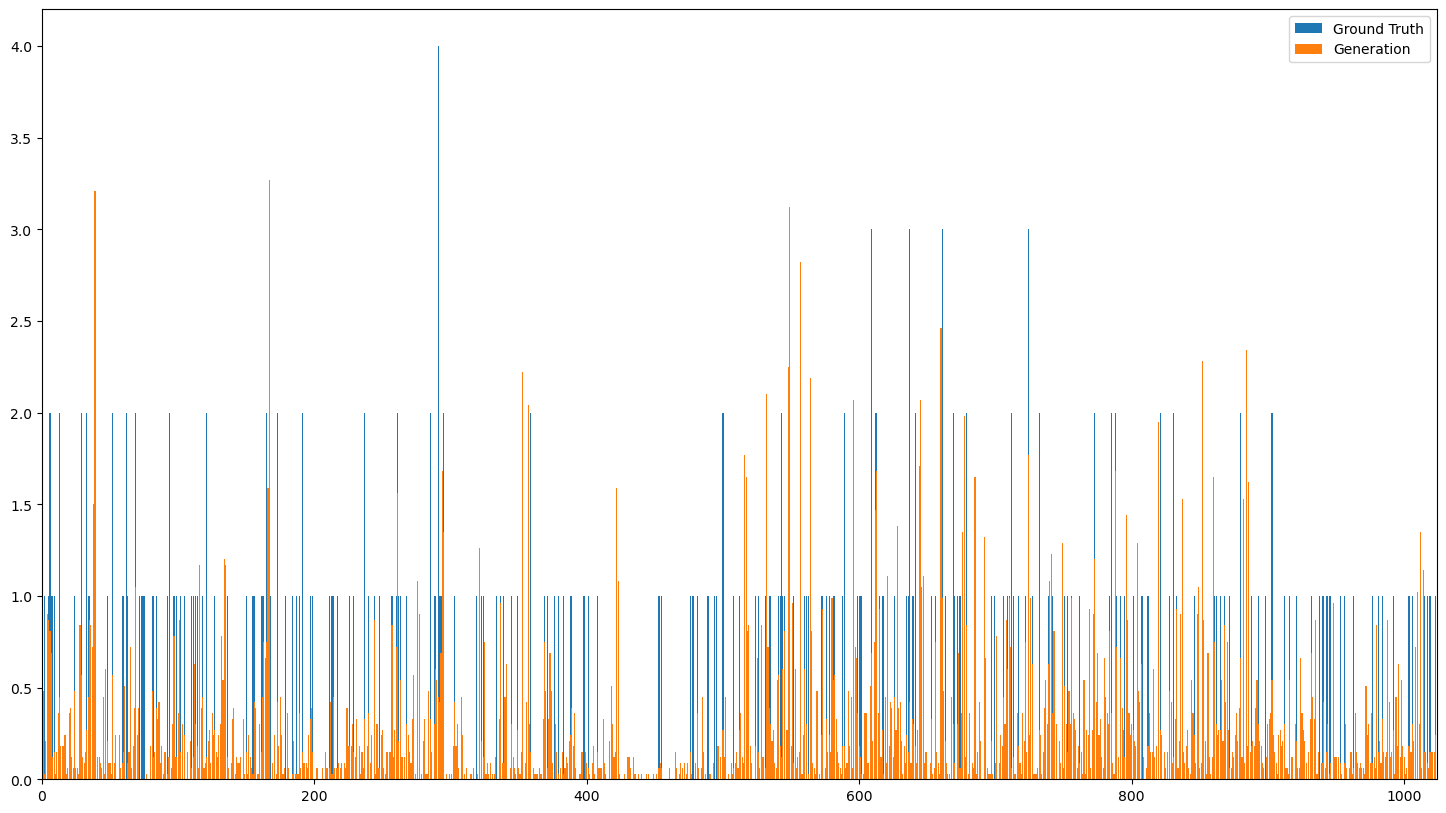

In [1719]:
# visualization (original order)
x_lim = 2**HM.n_d
fig, ax = plt.subplots(figsize=(18, 10))
ax.bar(values_d, dist_d,label = "Ground Truth")
ax.bar(values_g,dist_g,label = "Generation")
ax.set(xlim=(0, x_lim))
plt.legend()

In [1021]:
reordered_set = np.append(values_d,np.where(np.in1d(np.arange(0,x_lim),values_d,invert=True)))
reordered_set

array([ 650,  651,  652, ..., 1008, 1009, 1017], dtype=int64)

In [1022]:
xy, g_ind, re_ind = np.intersect1d(values_g, reordered_set, return_indices=True)

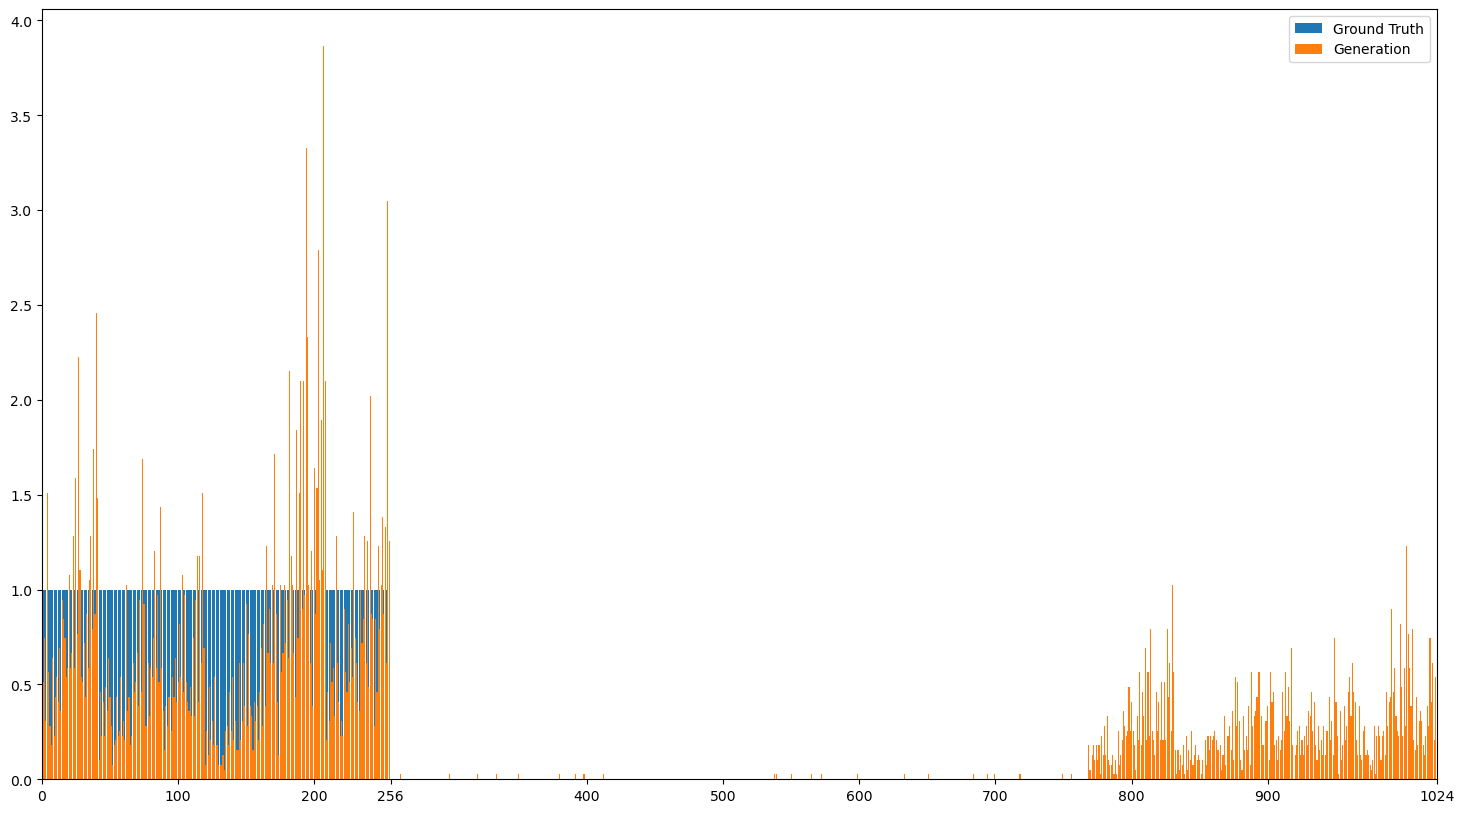

In [1023]:
# visualization (re-order)
x_lim = 2**HM.n_d
n_ticks = 8
xtick = np.arange(0,x_lim,int(x_lim/n_ticks/100+0.5)*100)
xtick[np.argmin(np.abs(xtick - counts_d.size))] = counts_d.size
xtick[-1] = x_lim

fig, ax = plt.subplots(figsize=(18, 10))
ax.bar(np.arange(counts_d.size),dist_d,label = "Ground Truth")
ax.bar(np.sort(re_ind),dist_g[np.argsort(re_ind)],label = "Generation")
ax.set(xlim=(0, x_lim), xticks=xtick)
plt.legend()

#### Post-processing

In [560]:
# HM.Norm_wake
# HM.Norm_sleep
# HM.norm_update()

In [685]:
HM.check_learning_rate(Alpha_P,Alpha_Q)

delta_loss: 0.05438910316629375 delta_f: 0.05638372414047777
learning rate change: 0.06804622607667567
delta_loss: 0.016245949003610094 delta_f: 0.016597544835692143
learning rate change: 0.08256297998449529
delta_loss: 0.00100050853950151 delta_f: 0.0010051795081557305
learning rate change: 0.09664104923354642
delta_loss: 0.07150847706109653 delta_f: 0.07195960043278823
learning rate change: 0.09632229959867626
delta_loss: 0.1887106331828612 delta_f: 0.18983020678770893
learning rate change: 0.09626077653282775
delta_loss: 0.15021801480739239 delta_f: 0.15449018873574802
learning rate change: 0.08361333660640764
delta_loss: 0.16437682773261697 delta_f: 0.1691848956994138
learning rate change: 0.0792985805094706


In [679]:
HM.lr

array([[0.09223127, 0.0965636 , 0.0994897 , 0.1       ],
       [0.09640789, 0.09784066, 0.09949712, 0.09955754]])

In [686]:
HM.norm_update()

mean:  [[ 0.20505972]
 [-2.34546241]
 [-1.12998377]
 [-2.20587891]
 [ 4.23259693]
 [ 1.67613006]
 [-2.53318631]
 [-3.15303168]]
variance:  [[ 9.5840907 ]
 [ 4.93115383]
 [10.75898034]
 [ 6.57241381]
 [ 3.01927054]
 [ 4.29380434]
 [ 7.21834511]
 [ 3.81451885]]
mean:  [[ 0.49790018]
 [-3.28049798]
 [-1.78900284]
 [-3.09031354]
 [ 2.10576247]
 [ 3.13281887]]
variance:  [[9.62717795]
 [4.15156993]
 [2.48673745]
 [2.60442977]
 [5.24644926]
 [2.02691862]]
mean:  [[ 3.59183105]
 [ 1.9120008 ]
 [-2.38617924]]
variance:  [[2.8296228 ]
 [2.07283743]
 [6.51634957]]
mean:  [[ 2.99705049]
 [ 1.7650585 ]
 [-1.96320875]]
variance:  [[0.9919234 ]
 [1.26148602]
 [3.85914269]]
mean:  [[ 0.72382662]
 [-3.0462023 ]
 [-1.64544818]
 [-2.93320947]
 [ 1.89010369]
 [ 3.11356005]]
variance:  [[3.88699664]
 [3.0803616 ]
 [1.78767406]
 [1.89114895]
 [2.90990065]
 [1.8444683 ]]
mean:  [[ 0.17705639]
 [-1.9474096 ]
 [-0.53805177]
 [-1.58487726]
 [ 4.1729943 ]
 [ 1.66812241]
 [-1.99651384]
 [-2.99240441]]
variance: 

In [1261]:
HM.prob_matrix()

In [1498]:
HM.Prob_mtx_wake['Prob_12'][:,-1]

array([4.15888308, 1.6026435 , 1.54191883, 4.05182657, 1.13117255,
       2.47574146, 0.84914124, 1.11057367, 1.42324828, 2.11913664,
       1.87224667, 1.56805419, 1.96717821, 1.6683238 , 0.50787017,
       1.80186696, 2.943097  , 1.6153151 , 2.06727769, 3.15733438,
       2.30347043, 2.56520868, 1.1098868 , 2.141564  , 1.20750777,
       1.8468537 , 1.63167354, 1.22179728, 1.56914046, 1.3551652 ,
       1.17200027, 1.67760733, 1.48653911, 1.42668707, 2.1046045 ,
       1.20204613, 2.05460493, 0.70418627, 0.59523651, 2.09278418,
       2.65223476, 2.07489558, 1.07142565, 2.45381939, 0.9846837 ,
       2.62191631, 0.10535773, 0.9085679 , 2.24637625, 2.16353798,
       1.71804373, 1.87125311, 1.82330209, 1.23389537, 0.79127325,
       1.72415463, 2.2365382 , 1.24615391, 1.96149212, 2.35461751,
       1.38964204, 3.14904622, 0.25074432, 1.23946851, 2.28819933,
       2.70275918, 1.15374625, 2.43416832, 1.0384842 , 1.96811814,
       0.47524835, 0.81290594, 0.90915943, 1.82412822, 0.97362

In [1227]:
np.log(2**6)

4.1588830833596715

In [1263]:
HM.Prob_mtx_sleep['Prob_32'][:,-1]

array([4.15888308, 1.46899102, 2.39385178, 1.67337806, 2.9677934 ,
       1.01966291, 2.12550257, 1.01882204])

In [1265]:
HM.Prob_mtx_sleep['Prob_32'][1,:]

array([3.70050677e-02, 5.00777871e-03, 2.35999519e-03, 3.19370681e-04,
       6.54096777e-01, 8.85168469e-02, 4.17149688e-02, 5.64515472e-03,
       2.41645666e-03, 3.27011433e-04, 1.54109328e-04, 2.08551276e-05,
       4.27129745e-02, 5.78021167e-03, 2.72401648e-03, 3.68632530e-04,
       2.21056629e-03, 2.99148941e-04, 1.40978686e-04, 1.90781994e-05,
       3.90736830e-02, 5.28771786e-03, 2.49192096e-03, 3.37223778e-04,
       1.44351516e-04, 1.95346339e-05, 9.20600624e-06, 1.24581969e-06,
       2.55153868e-03, 3.45291655e-04, 1.62724172e-04, 2.20209472e-05,
       2.26650134e-03, 3.06718454e-04, 1.44545939e-04, 1.95609445e-05,
       4.00623837e-02, 5.42151560e-03, 2.55497527e-03, 3.45756718e-04,
       1.48004114e-04, 2.00289284e-05, 9.43895037e-06, 1.27734328e-06,
       2.61610152e-03, 3.54028740e-04, 1.66841662e-04, 2.25781542e-05,
       1.35393657e-04, 1.83223952e-05, 8.63471950e-06, 1.16850927e-06,
       2.39320072e-03, 3.23864280e-04, 1.52626182e-04, 2.06544182e-05,
      